In [731]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [732]:
def sentiment_transform(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [733]:
def prepare_data(ticker):
    stock_price = pd.read_csv(f"../dataset/stocks/{ticker}.csv")
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()
    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    
    stock_news = pd.read_csv(f"../dataset/polygon_title_sentiment/{ticker}_title_sentiments.csv")
    stock_news['time'] = pd.to_datetime(stock_news['time'])
    stock_news['trade_date'] = (stock_news['time'] + pd.to_timedelta(0, unit='h')).dt.date
    stock_news['neg_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_score'] = np.nan

    news_comb = pd.merge(stock_price, stock_news, how='left', on='trade_date')
    relation_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first', 'open': 'first', 'high': 'first', 'low': 'first',
        'sentiment': [sentiment_transform(['positive']), sentiment_transform(['negative'])], 'neg_score': 'mean'
    }).fillna(0.0).reset_index()
    relation_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'open', 'high', 'low', 'positive', 'negative', 'neg_score']
    return relation_gp

In [734]:
relation_gp = prepare_data(ticker='MSFT')
relation_gp_t = relation_gp[relation_gp['negative'] > 0]
len(relation_gp_t), len(relation_gp)

/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_26019/2186838793.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return series.isin(label).sum() / series.count()


(408, 502)

In [735]:
def test_relevance(cols):
    X, y = relation_gp_t[cols], relation_gp_t['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2, model.coef_

In [736]:
test_relevance(['negative'])

(25.414213675177788, 0.02134127080702819, array([-6.82111224]))

In [737]:
test_relevance(['negative', 'prv_close'])

(25.136736447226873,
 0.032026453309906944,
 array([-7.76132855e+00, -7.70103736e-03]))

In [738]:
test_relevance(['neg_score', 'prv_close'])

(25.698480840800066, 0.010394619196441135, array([-3.2193693 , -0.00597954]))

In [739]:
test_relevance(['negative', 'neg_score', 'prv_close'])

(25.03698803049682,
 0.03586759748236634,
 array([-7.60319963, -2.82916479, -0.0081833 ]))

In [740]:
test_relevance(['positive', 'negative', 'prv_close'])

(24.89207899847681,
 0.041447801180102495,
 array([ 3.73650403, -7.31033625, -0.01037379]))

In [741]:
test_relevance(['positive', 'negative', 'neg_score', 'prv_close'])

(24.761566117140347,
 0.04647363326857701,
 array([ 3.98025502, -7.09931802, -3.24905713, -0.01110198]))

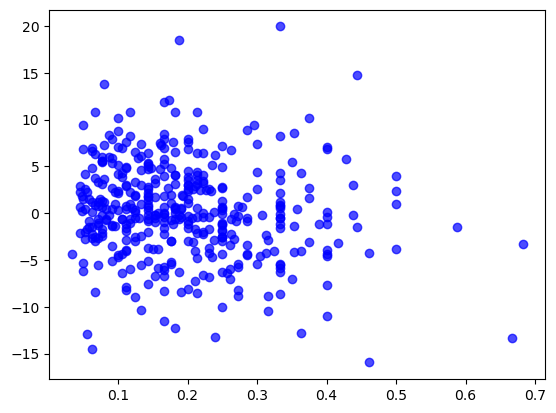

In [742]:
import matplotlib.pyplot as plt

plt.scatter(relation_gp_t['negative'], relation_gp_t['delta'], color='blue', alpha=0.7)

In [743]:
def preprocess(relation_gp, feat_cols):
    seq_length = 10
    std_scaler = StandardScaler()
    df = pd.DataFrame()
    df[feat_cols] = std_scaler.fit_transform(relation_gp[feat_cols])

    X = []
    y = []
    for i in range(seq_length, len(df)):
        X.append(df.iloc[i-seq_length:i])
        y.append(df.iloc[i, -1])
    X = np.array(X)
    y = np.array(y)

    split_index = int(len(X) * 0.95)
    X, X_test = X[:split_index], X[split_index:]
    y, y_test = y[:split_index], y[split_index:]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=67)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) 
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) 
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) 

    return X_train, X_val, X_test, y_train, y_val, y_test

In [744]:
class SimpleLSTM(nn.Module):
    def __init__(self, feat_size, layers, dropout):
        super(SimpleLSTM, self).__init__()
        self.fc1 = nn.Linear(feat_size[0], feat_size[1])
        self.lstm = nn.LSTM(feat_size[1], feat_size[2], num_layers=layers, dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(feat_size[2], feat_size[3])
    
    def forward(self, x):
        inp = self.fc1(x)
        lstm_out, (hn, cn) = self.lstm(inp)
        out = self.fc2(hn[-1])
        return out

In [745]:
feat_cols = ['negative', 'close']
model = SimpleLSTM(feat_size=[len(feat_cols), 16, 64, 1], layers=2, dropout=0.5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(relation_gp, feat_cols)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([443, 10, 2]),
 torch.Size([24, 10, 2]),
 torch.Size([25, 10, 2]),
 torch.Size([443, 1]),
 torch.Size([24, 1]),
 torch.Size([25, 1]))

In [746]:
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

Epoch 1, Train Loss: 0.9643, Test Loss: 1.2424
Epoch 2, Train Loss: 0.9290, Test Loss: 1.1651
Epoch 3, Train Loss: 0.8959, Test Loss: 1.0866
Epoch 4, Train Loss: 0.8579, Test Loss: 1.0057
Epoch 5, Train Loss: 0.8234, Test Loss: 0.9209
Epoch 6, Train Loss: 0.7814, Test Loss: 0.8308
Epoch 7, Train Loss: 0.7387, Test Loss: 0.7348
Epoch 8, Train Loss: 0.6917, Test Loss: 0.6330
Epoch 9, Train Loss: 0.6346, Test Loss: 0.5260
Epoch 10, Train Loss: 0.5795, Test Loss: 0.4159
Epoch 11, Train Loss: 0.5097, Test Loss: 0.3064
Epoch 12, Train Loss: 0.4389, Test Loss: 0.2032
Epoch 13, Train Loss: 0.3639, Test Loss: 0.1146
Epoch 14, Train Loss: 0.2900, Test Loss: 0.0505
Epoch 15, Train Loss: 0.2188, Test Loss: 0.0202
Epoch 16, Train Loss: 0.1615, Test Loss: 0.0281
Epoch 17, Train Loss: 0.1161, Test Loss: 0.0649
Epoch 18, Train Loss: 0.0940, Test Loss: 0.1077
Epoch 19, Train Loss: 0.0894, Test Loss: 0.1333
Epoch 20, Train Loss: 0.0931, Test Loss: 0.1363
Epoch 21, Train Loss: 0.1189, Test Loss: 0.1216
E

In [747]:
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    std = y_test.std()
    print(f'Test Loss: {loss.item():.4f}')
    print(f'Std: {std:.4f}')
    print(f'Error Range: {loss.sqrt() / std:.4f}')

Test Loss: 0.0057
Std: 0.0946
Error Range: 0.7983
